## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `1_create_netcdf` 
### Script to create a netcdf from the `raw_tif` files 

Notebook contents 
* Import all raw tif files and create a simple netcdf file for future analysis 
* Check datasets for nans, out of range values, and do simple cleaning 

created by Cassie Lumbrazo\
last updated: June 2024\
run location: linux box\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [9]:
# Import Raw TIF datasets and merge info a single netcdf

# digital terrain model (dtm) and digital surface model (dsm)
tif_dtm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dtm_snowoff.tif", masked=True) # snow-off dataset
tif_dsm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dsm_snowoff.tif", masked=True) # snow-off dataset
tif_dtm_ncalm   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dtm_ncalm.tif",   masked=True) # snow-on dataset
tif_dsm_ncalm   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dsm_ncalm.tif",   masked=True) # snow-on dataset
tif_dtm_rapid   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dtm_rapid.tif",   masked=True) # snow-on dataset
tif_dsm_rapid   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dsm_rapid.tif",   masked=True) # snow-on dataset

# cer landscape metrics 
tif_aspect = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_aspect.tif", masked=True)
tif_slope  = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_slope.tif", masked=True)
tif_dah    = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dah.tif", masked=True)
tif_tpi    = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_tpi.tif", masked=True)

# canopy height model (chm) and canopy height models with snow (chmws) for snow-on datasets 
tif_chm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_chm_snowoff.tif", masked=True)
tif_chmws_ncalm = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_chmws_ncalm.tif", masked=True)
tif_chmws_rapid = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_chmws_rapid.tif", masked=True)

# distance to canopy edge (dce) 
tif_dce_snowoff = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dce_snowoff.tif", masked=True)
tif_dce_ncalm   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dce_ncalm.tif", masked=True)
tif_dce_rapid   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_dce_rapid.tif", masked=True)

tif_giulia_dce_snowoff = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_giulia_dce_snowoff.tif", masked=True)
tif_giulia_dce_ncalm   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_giulia_dce_ncalm.tif", masked=True)
tif_giulia_dce_rapid   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_giulia_dce_rapid.tif", masked=True)

# snow depth (height snow: hs)
tif_hs_ncalm = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_hs_ncalm.tif", masked=True)
tif_hs_rapid = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_hs_rapid.tif", masked=True)

# cer treatment related rasters
# tif_baf_old = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/BAF_merged_raster_3.tif", masked=True) # this is the old BAF polygons, we do not need this anymore
tif_baf   = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/updated_BAF_polygons_all.tif", masked=True) # this is the complete BAF map with all the extra polygons
tif_ridge = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/side_of_ridge_raster.tif", masked=True) # this is just a simple raster defining the side of the ridge
tif_plots = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_timeseries_plot_squares.tif", masked=True) # raster with outlines of timeseries plots
tif_road  = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/ridge_road_raster.tif", masked=True) # this is just a binary raster defining the ridge road to clip everything to
tif_boundary = rioxarray.open_rasterio("/storage/lumbraca/cer_treatment_manuscript_datasets/cer_rapid_conservative_boundary_raster.tif", masked=True) # this provides a conservative boundary to clip everythig to based on the quality of the rapid lidar

# Put all the TIFs together into a single xarray dataset 
ds = xr.Dataset({"dsm_rapid":tif_dsm_rapid, # this is the raster which everything else is going to reproject and match with using rasterio
                 "dtm_rapid":tif_dtm_rapid.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_ncalm":tif_dtm_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_ncalm":tif_dsm_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_snowoff":tif_dtm_snowoff.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_snowoff":tif_dsm_snowoff.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "aspect":tif_aspect.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "slope":tif_slope.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dah":tif_dah.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "tpi":tif_tpi.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "chm_snowoff":tif_chm_snowoff.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "chmws_ncalm":tif_chmws_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "chmws_rapid":tif_chmws_rapid.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "dce_snowoff":tif_dce_snowoff.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dce_ncalm":tif_dce_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "dce_rapid":tif_dce_rapid.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "giulia_dce_snowoff":tif_giulia_dce_snowoff.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "giulia_dce_ncalm":tif_giulia_dce_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "giulia_dce_rapid":tif_giulia_dce_rapid.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "hs_ncalm":tif_hs_ncalm.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "hs_rapid":tif_hs_rapid.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 
                 "baf":tif_baf.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "baf_ridge":tif_ridge.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "baf_plots":tif_plots.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "road":tif_road.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 "boundary":tif_boundary.rio.reproject_match(tif_dsm_rapid, resampling = rasterio.enums.Resampling.bilinear),
                 })

In [10]:
# close all the datasets to save memory 
# snowoff and ncalm
tif_dtm_snowoff.close()
tif_dsm_snowoff.close()
tif_dtm_ncalm.close()
tif_dsm_ncalm.close()
tif_dtm_rapid.close()
tif_dsm_rapid.close()

tif_aspect.close()
tif_slope.close()
tif_dah.close()
tif_tpi.close()

tif_chm_snowoff.close()
tif_chmws_ncalm.close()
tif_chmws_rapid.close()

tif_dce_snowoff.close()
tif_dce_ncalm.close()
tif_dce_rapid.close()

tif_giulia_dce_snowoff.close()
tif_giulia_dce_ncalm.close()
tif_giulia_dce_rapid.close()

tif_hs_ncalm.close()
tif_hs_rapid.close()

tif_baf.close()
tif_ridge.close()
tif_plots.close()
tif_road.close()
tif_boundary.close()

In [11]:
ds

<xarray.Dataset>
Dimensions:             (band: 1, x: 2581, y: 1418)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 4.65e+05 4.65e+05 ... 4.676e+05 4.676e+05
  * y                   (y) float64 2.111e+05 2.111e+05 ... 2.097e+05 2.097e+05
    spatial_ref         int64 0
Data variables: (12/26)
    dsm_rapid           (band, y, x) float32 ...
    dtm_rapid           (band, y, x) float32 nan nan nan nan ... nan nan nan nan
    dtm_ncalm           (band, y, x) float32 3.39e+03 3.39e+03 ... 2.884e+03
    dsm_ncalm           (band, y, x) float32 3.39e+03 3.39e+03 ... 2.884e+03
    dtm_snowoff         (band, y, x) float32 1.033e+03 1.033e+03 ... 879.0 879.0
    dsm_snowoff         (band, y, x) float32 1.033e+03 1.035e+03 ... 879.0 879.0
    ...                  ...
    hs_rapid            (band, y, x) float32 nan nan nan nan ... nan nan nan nan
    baf                 (band, y, x) float32 0.0 0.0 0.0 ... 3.403e+38 3.403e+38
    baf_ridge           (band, y, x) float32 1.0 1.0 1.0 ... 3.403e+38 3.403e+38
    baf_plots           (band, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38
    road                (band, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38
    boundary            (band, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38

In [12]:
# First, fix the issue of large values from the binary boundary 
# remove any huge values in all of ds 
ds = ds.where(ds < 5000) # cannot be something as low as 1000 because of elevation dtm
ds = ds.where(ds > -5000)

# make all values of the dataset nan where the values of the rapid chmws dataset are nan for now
ds = ds.where(ds.chmws_rapid.notnull())

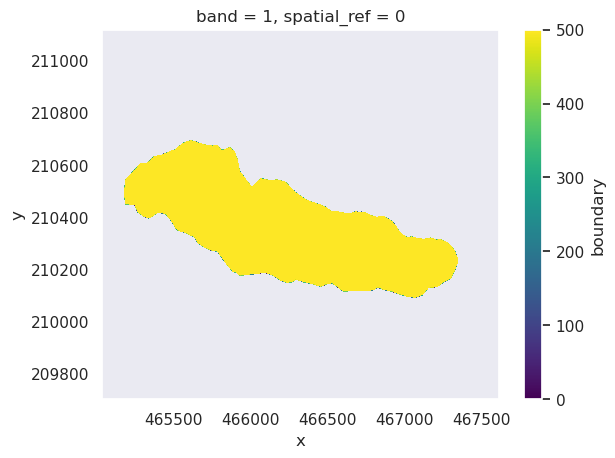

In [13]:
ds['boundary'].plot()

Clean up a few weird values around the edges, because this should be binary

In [14]:
ds['boundary'] = ds['boundary'].where(ds['boundary'] == 500) # make everything that is not 500 nan

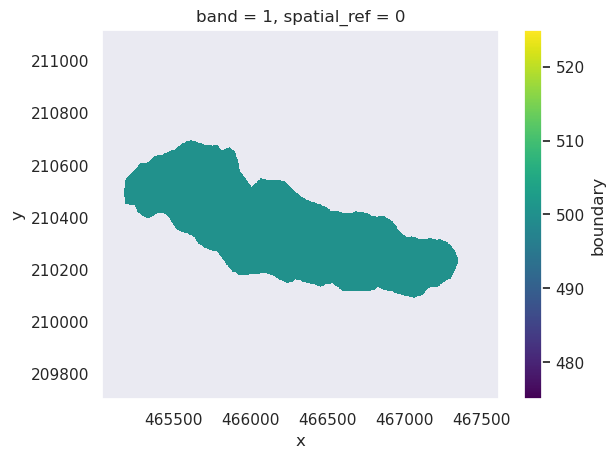

In [15]:
ds['boundary'].plot()

Good, now boundary variable is binary.\
Now set the entire dataset to the boundary region only.

In [16]:
# now, make the entire rapid dataset nan where the boundary varible is nan
ds = ds.where(ds['boundary'].notnull())

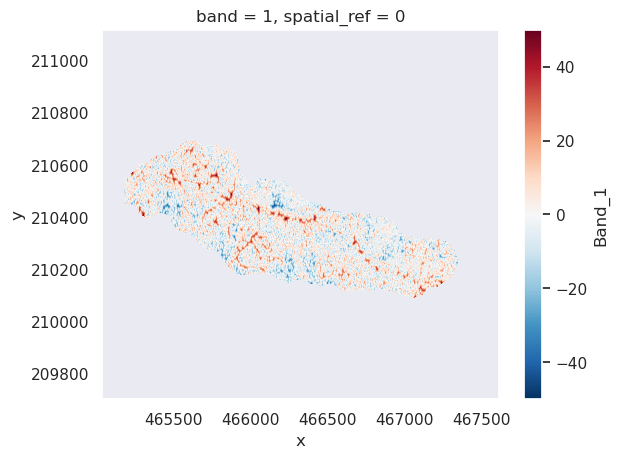

In [17]:
ds['dce_rapid'].plot()

Now, look at some things then save after

In [23]:
# where BAF is 0 in the raster, set this to nan
ds['baf'] = ds['baf'].where(ds['baf']> 0)

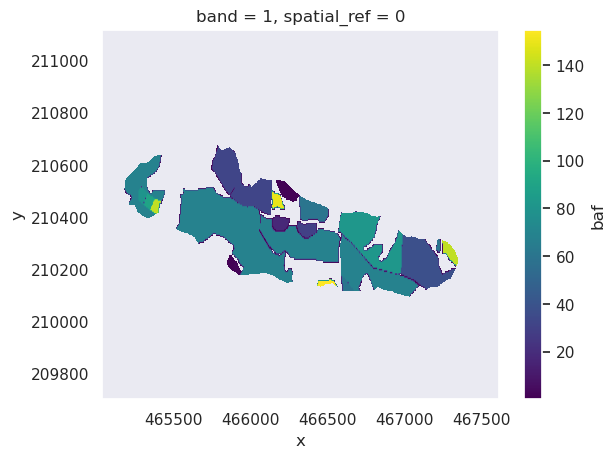

In [24]:
ds['baf'].plot()

Taking a look at the other binary rasters we will need to use later to define regions on the ridge

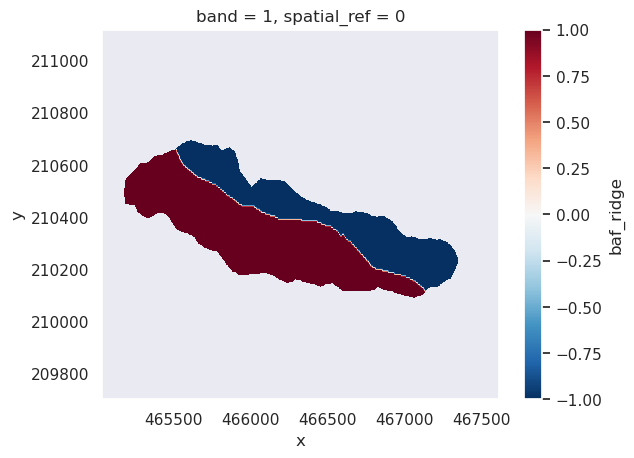

In [25]:
ds['baf_ridge'].plot()

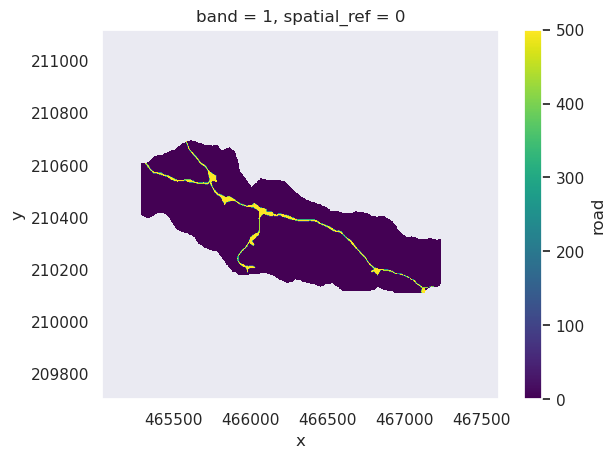

In [26]:
ds['road'].plot()

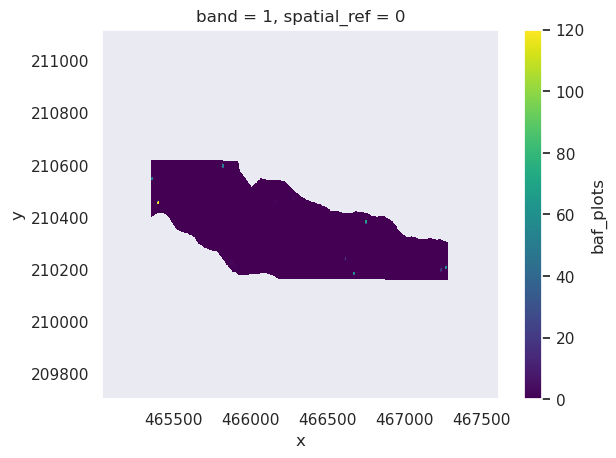

In [27]:
ds['baf_plots'].plot()

Only keep data for those two where the dataset is greater than 0.

In [28]:
ds['baf_plots'] = ds['baf_plots'].where(ds['baf_plots'] > 0)
ds['road'] = ds['road'].where(ds['road'] > 0)

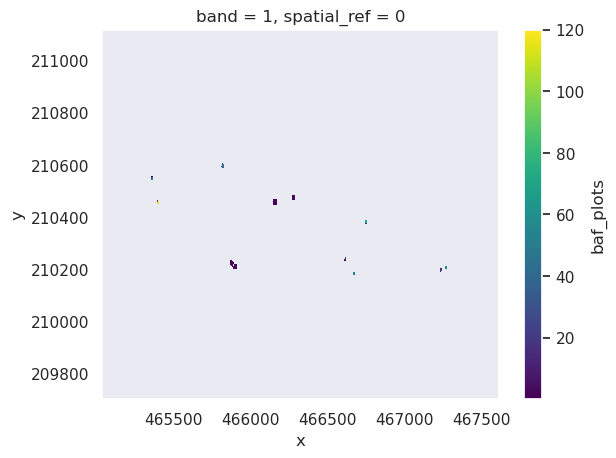

In [29]:
ds['baf_plots'].plot()

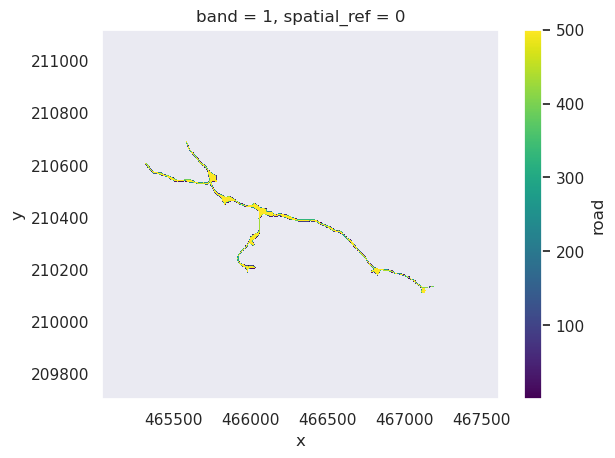

In [30]:
ds['road'].plot()

`baf_ridge` defines the side of the ridge just using the ridge road where `-1` is the north, and `1` is the soouth side.\
`baf_plots` is the ~10m x 10m plots around the timeseries sites, converted into a raster dataset.\
The values for `baf_plots` are as follows,\
`1`: CNF and CSF, 2: CNG and CSG \
`20`: CN20, CS20 \
`50`: CN50, CS50 \
`60`: CN60, CS60 \
`70`: CN70 \
`120`: CS120 

Then use `baf_ridge` to determine which `baf_plots` are on the north or south side of the side. 

In [31]:
# Because this takes so long to create, let's save all the raw files into a netcdf, before cleaning up the dataset and resaving 
ds.to_netcdf('/home/lumbraca/raster/data/cer_treatment_region_dataset_raw.nc') 

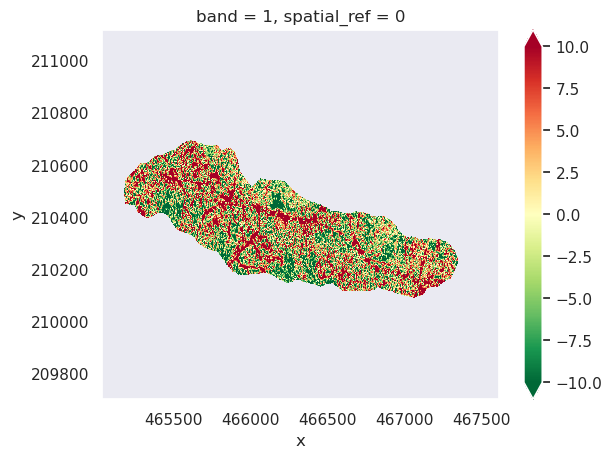

In [32]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

Remembering that these dce values are in feet, so we need to change them to meters to match everything else. 

In [33]:
# Now, we need to convert the distance for all my dce to meters 
ds['dce_snowoff'] = ds['dce_snowoff'] * 0.3048
ds['dce_ncalm'] = ds['dce_ncalm'] * 0.3048
ds['dce_rapid'] = ds['dce_rapid'] * 0.3048

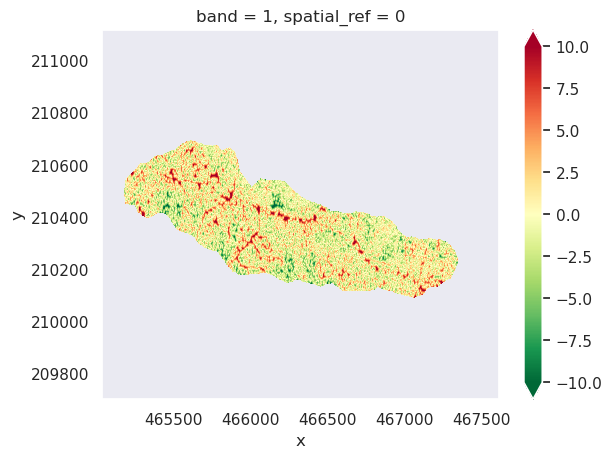

In [34]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

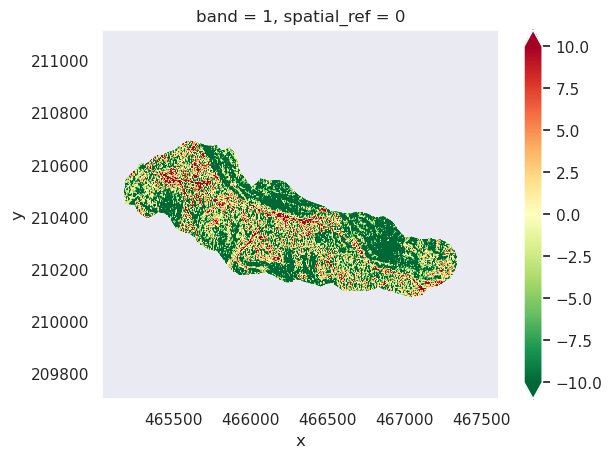

In [35]:
ds.giulia_dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

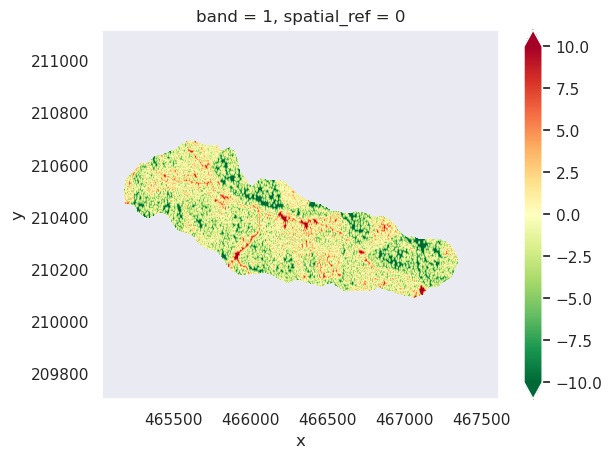

In [36]:
ds.dce_snowoff.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

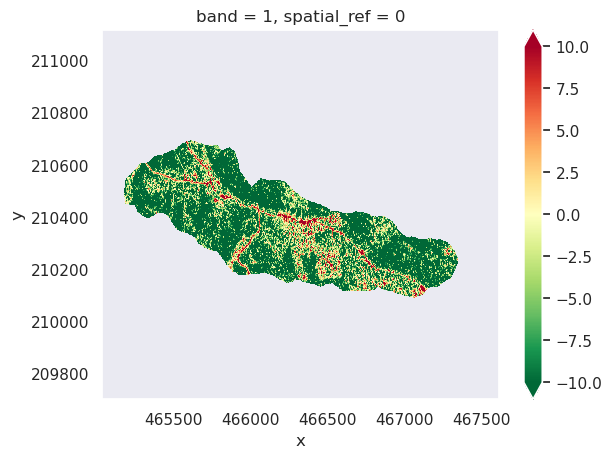

In [37]:
ds.giulia_dce_snowoff.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

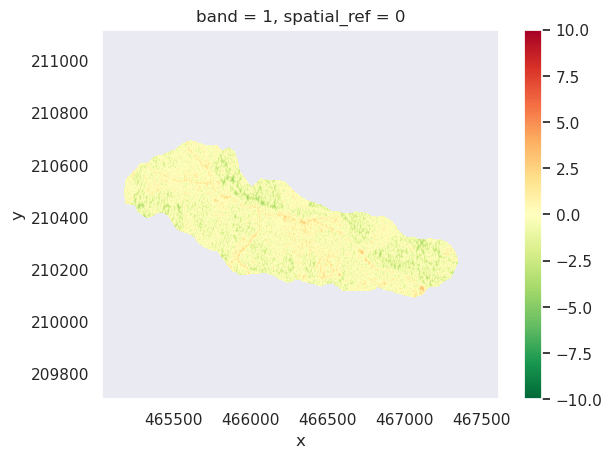

In [38]:
ds.dce_ncalm.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

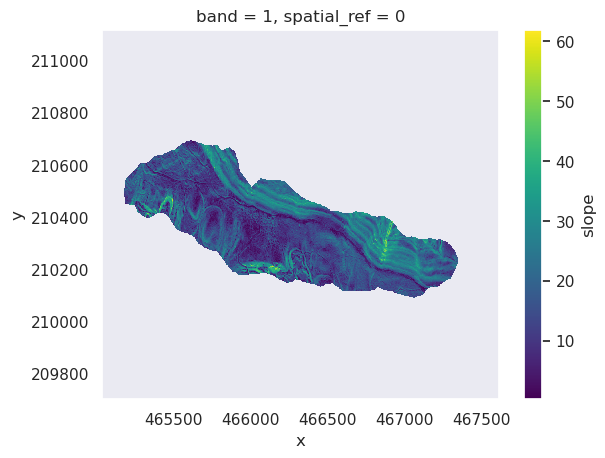

In [39]:
ds.slope.plot()

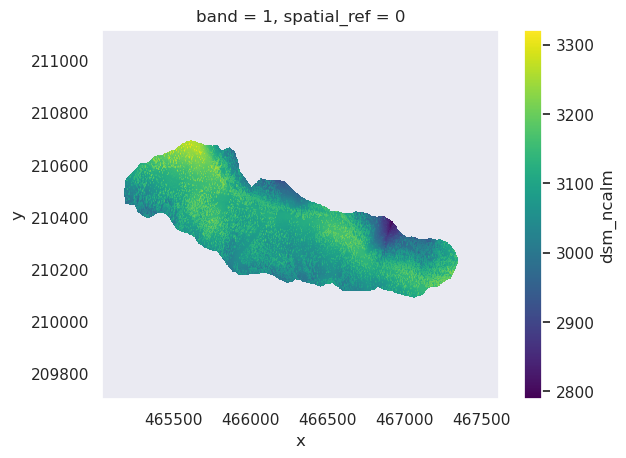

In [40]:
ds['dsm_ncalm'].plot()

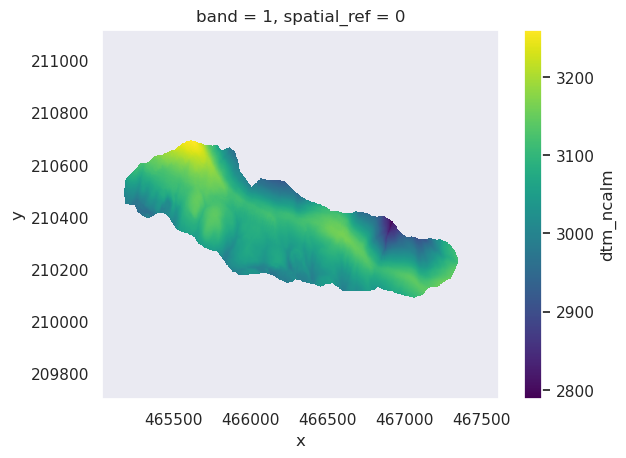

In [41]:
ds['dtm_ncalm'].plot()

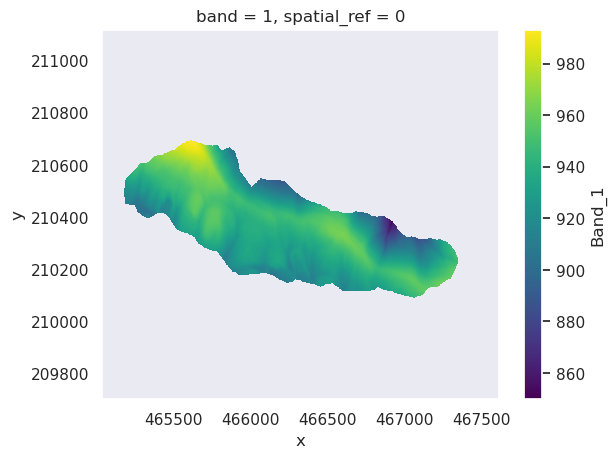

In [42]:
ds['dtm_snowoff'].plot()

Plotting everything to make sure the units are all correct. I need to convert ncalm dtm and dsm to meters. Check rapid first...

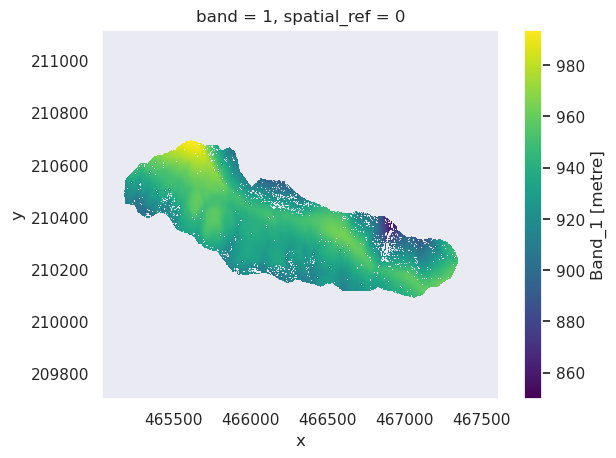

In [43]:
ds['dtm_rapid'].plot()

## Clean up the datasets 

The NCALM rasters are still in feet, but we already conversted the snow off to meters.

In [44]:
# ncalm dtm and dsm are in feet, need to conver to meters
ds['dtm_ncalm'] = ds['dtm_ncalm']*0.3048
ds['dsm_ncalm'] = ds['dsm_ncalm']*0.3048

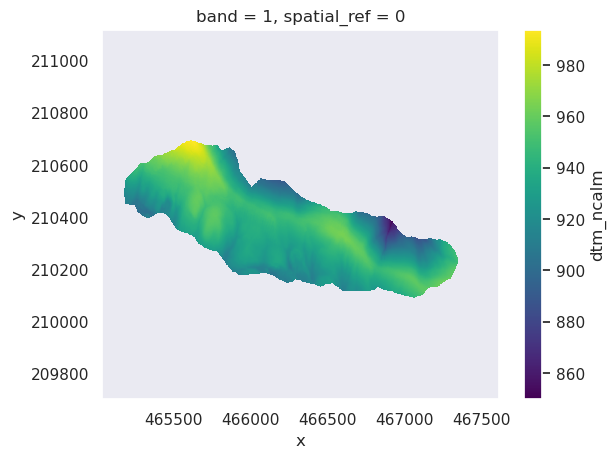

In [45]:
ds.dtm_ncalm.plot() # check the units and make sure they are in meters 

Okay, now we can calculate snow depth from both dtms in meters.

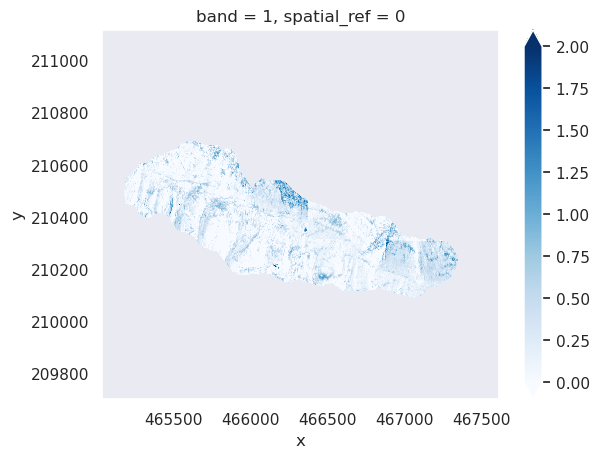

In [46]:
# recalculate snow depth using python for ncalm to match the way it was done for rapid
# ds['hs_ncalm'] = ds.dtm_ncalm - ds.dtm_snowoff # we imported a hs_ncalm, look at that first
ds.hs_ncalm.plot(cmap='Blues', vmin=0, vmax=2, cbar_kwargs={'label':''})

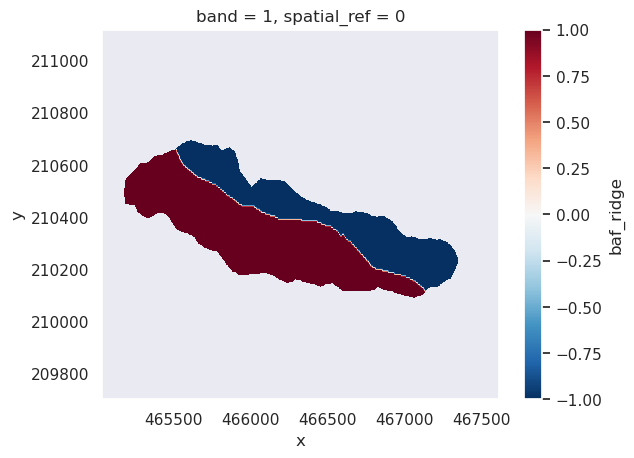

In [47]:
ds.baf_ridge.plot()

okay great. Now, we can get to cleaning all different datasets. 

### Remove Random Outliers, 
most should not have, but just to be sure, make nan

In [48]:
# the general data for cer  
ds['dem'] = ds['dtm_snowoff'].copy(deep=True) #save dem as a variable 

ds['slope'] = ds['slope'].where(ds['slope'] >= 0, drop=True) # keep slope above 0
ds['aspect'] = ds['aspect'].where(ds['aspect'] >= -1, drop=True) # keep aspect above -1 

ds['tpi'] = ds['tpi'].where(~(ds['tpi'] >  100), drop=True) # removing strange tpi values 
ds['tpi'] = ds['tpi'].where(~(ds['tpi'] < -100), drop=True) # removing strange tpi values 

ds['dah'] = ds['dah'].where(~(ds['dah'] > 50), drop=True) # droping any gaps that are bigger than 50
ds['dah'] = ds['dah'].where(~(ds['dah'] < -50), drop=True) # droping any gaps that are smaller than -50


# clean dce and chm
ds['chm_snowoff'] = ds['chm_snowoff'].where(ds['chm_snowoff'] >= 0, drop=True) # keep canopy height model above 0 
ds['chmws_ncalm'] = ds['chmws_ncalm'].where(ds['chmws_ncalm'] >= 0, drop=True) 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chmws_rapid'] >= 0, drop=True) 

ds['dce_snowoff'] = ds['dce_snowoff'].where(~(ds['dce_snowoff'] > 100), drop=True)  # droping any gaps that are bigger than 100
ds['dce_snowoff'] = ds['dce_snowoff'].where(~(ds['dce_snowoff'] < -100), drop=True) # droping any gaps that are smaller than -100
ds['dce_ncalm'] = ds['dce_ncalm'].where(~(ds['dce_ncalm'] > 100), drop=True) 
ds['dce_ncalm'] = ds['dce_ncalm'].where(~(ds['dce_ncalm'] < -100), drop=True)
ds['dce_rapid'] = ds['dce_rapid'].where(~(ds['dce_rapid'] > 100), drop=True)  
ds['dce_rapid'] = ds['dce_rapid'].where(~(ds['dce_rapid'] < -100), drop=True) 

ds['giulia_dce_snowoff'] = ds['giulia_dce_snowoff'].where(~(ds['giulia_dce_snowoff'] > 100), drop=True)  # droping any gaps that are bigger than 100, already cut it to 30 
ds['giulia_dce_snowoff'] = ds['giulia_dce_snowoff'].where(~(ds['giulia_dce_snowoff'] < -100), drop=True) # droping any gaps that are smaller than -100
ds['giulia_dce_ncalm'] = ds['giulia_dce_ncalm'].where(~(ds['giulia_dce_ncalm'] > 100), drop=True)  
ds['giulia_dce_ncalm'] = ds['giulia_dce_ncalm'].where(~(ds['giulia_dce_ncalm'] < -100), drop=True) 
ds['giulia_dce_rapid'] = ds['giulia_dce_rapid'].where(~(ds['giulia_dce_rapid'] > 100), drop=True)  
ds['giulia_dce_rapid'] = ds['giulia_dce_rapid'].where(~(ds['giulia_dce_rapid'] < -100), drop=True) 

In [49]:
ds['chm_rapid'].plot()

KeyError: 'chm_rapid'

Run the first cell below for making all zero snow depth values nan\
and run the second cell instead if you want to account for some negative values being 0 

In [39]:
# # cleaning snow depth (removing any 0 values)
# ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] >= 0, drop=True)  
# ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] < 3, drop=True) 

# ds['hs_rapid'] = ds['hs_rapid'].where(ds['hs_rapid'] >= 0, drop=True)  
# ds['hs_rapid'] = ds['hs_rapid'].where(ds['hs_rapid'] < 3, drop=True) 


Run the cell below to give both NCALM and RAPID 10cm of wiggle room negative 

In [50]:
# instead of removing everything < 0, we could say if it's between -.1 and 0, then make it 0 (accounting for small errors in the data)
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] > -.1, drop=True)  # so, start by dropping everything less than -1
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] > 0, 0)            # then, fill everything less than 0 with 0 (-1 to 0 basically)
ds['hs_ncalm'] = ds['hs_ncalm'].where(ds['hs_ncalm'] < 3, drop=True)    # then, drop everything greater than 3

ds['hs_rapid'] = ds['hs_rapid'].where(ds['hs_rapid'] > -.1, drop=True) 
ds['hs_rapid'] = ds['hs_rapid'].where(ds['hs_rapid'] > 0, 0) 
ds['hs_rapid'] = ds['hs_rapid'].where(ds['hs_rapid'] < 3, drop=True) 

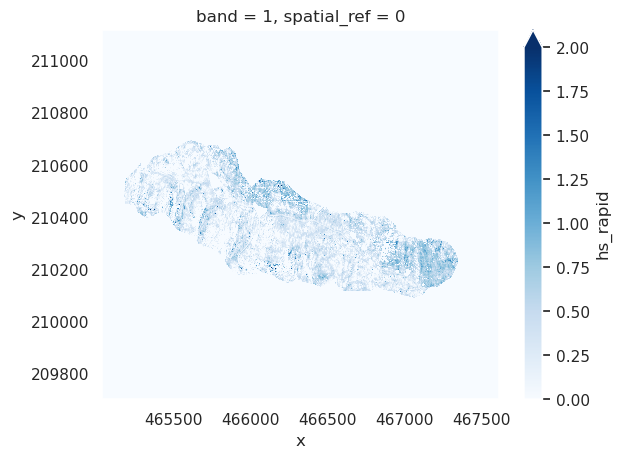

In [51]:
ds.hs_rapid.plot(cmap='Blues', vmin=0, vmax=2)

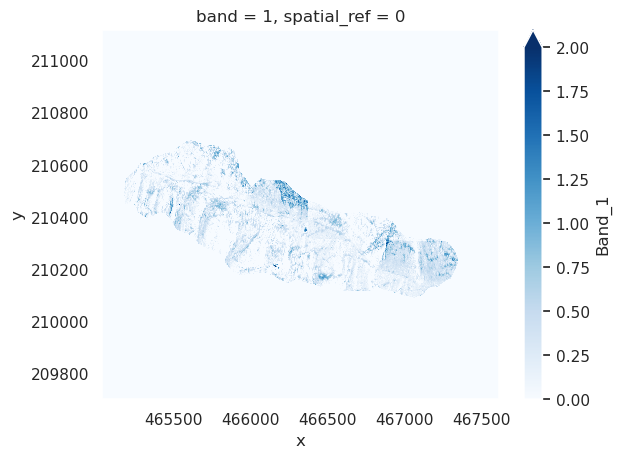

In [52]:
ds.hs_ncalm.plot(cmap='Blues', vmin=0, vmax=2)

## Create a buffer on DCE to remove edge effects 
* We need this around the edges a bit and around the road, so first make those areas nan using the rasters we created

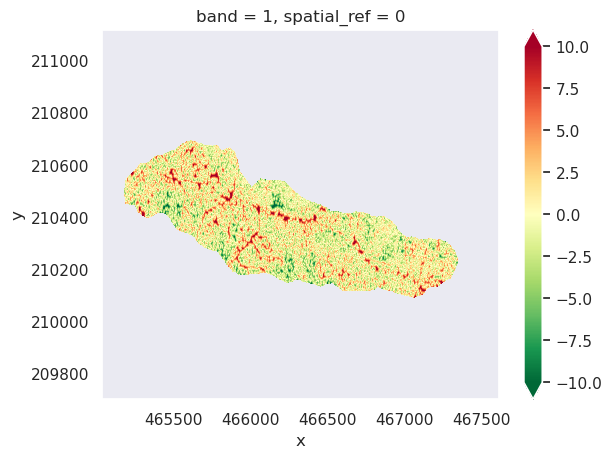

In [53]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

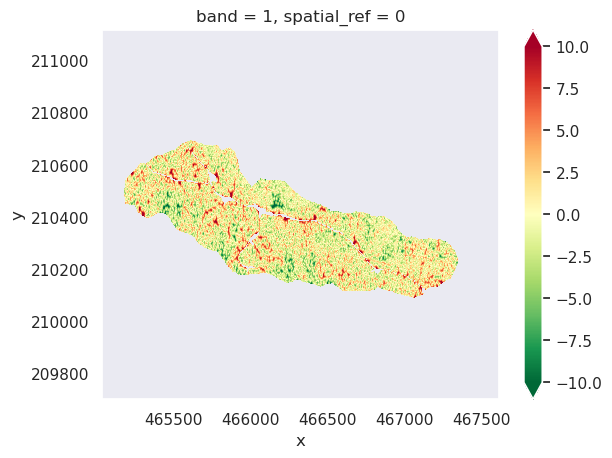

In [54]:
# we want to mask out the entire dataset where the road is present, so where ds['road'] == 500
ds = ds.where(ds['road'] != 500)

# then, we can add this buffer around the road too
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

Now create the DCE mask. 

In [55]:
# Creating a binary mask
# if there are values then 1, if not then 0 
dce_mask = ds['dce_rapid'].copy(deep=True) # first copy dce 
dce_mask = dce_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
dce_mask = dce_mask.where(dce_mask < -100, 1) # where condition is FALSE, fill with 1 
dce_mask = dce_mask.where(dce_mask > -100, 0) # where condition is FALSE, fill with 0 

buffer_num = 5 # this is the number we are going to mask as nan around other nans and buffer... 
# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(dce_mask, structure=np.ones((1,buffer_num,buffer_num))).astype(dce_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# Perhaps smaller than 20x20 is okay for this dataset? I can go check the dce in ArcGIS Pro to see the distance, and just make sure to write it up.
# I checked, and we really need ~ 20 meters to account for the edge effects in the dce 

# add the fixed mask to the dataset 
ds['mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['dce_rapid_raw'] = ds['dce_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['dce_rapid'] = ds['dce_rapid'].where(ds['mask'] >= 1) # resaving the mask dce into dce variable 

In [56]:
# Now, just say that anywhere ds['dce_rapid] is nan, then the entire dataset is nan
ds = ds.where(ds['dce_rapid'].notnull())

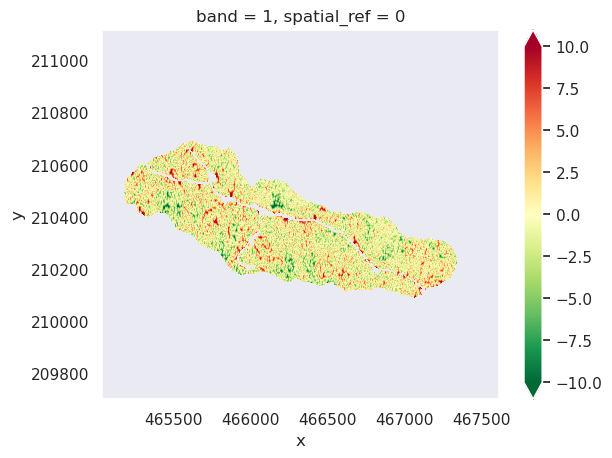

In [57]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

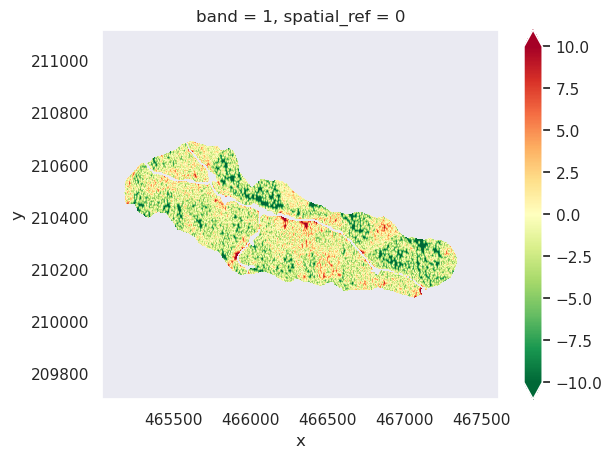

In [58]:
ds.dce_snowoff.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

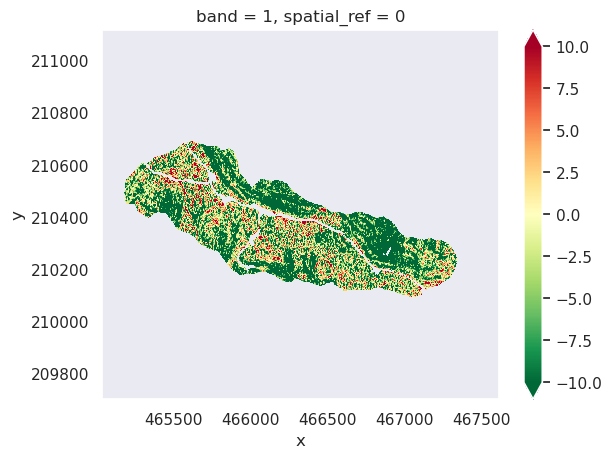

In [59]:
ds.giulia_dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

## Write to nedcdf 

Need to set everything to null again to make our main snow depth result 

In [60]:
# If we want, the canopy height model above snow to the dataset
ds['chmas_ncalm'] = ds['chmws_ncalm'] - ds['hs_ncalm']
ds['chmas_rapid'] = ds['chmws_rapid'] - ds['hs_rapid']

In [ ]:
# run the line below if you want to remove all values where snow depth = nan
# ds = ds.where(ds.hs_rapid.notnull())

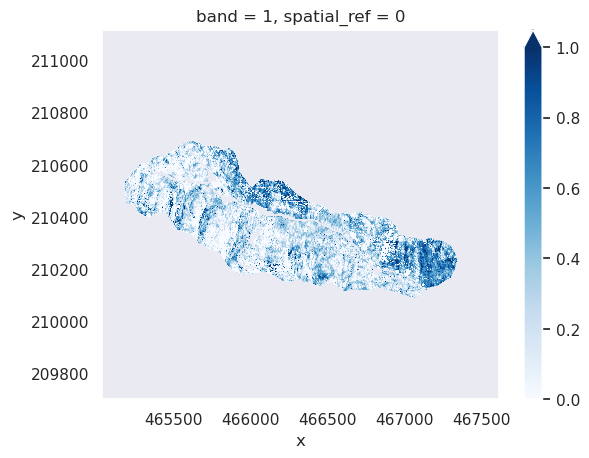

In [61]:
ds['hs_rapid'].plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

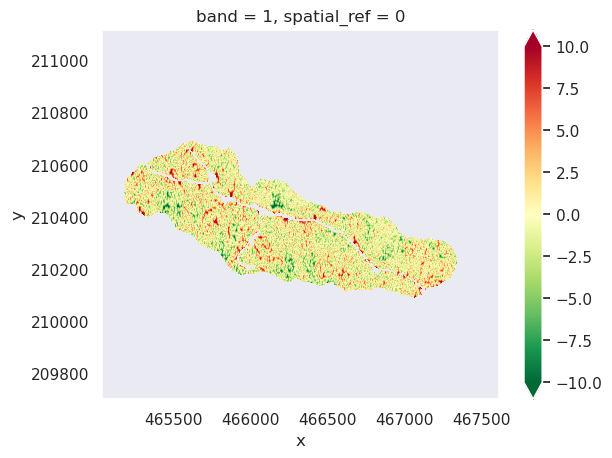

In [62]:
ds.dce_rapid.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

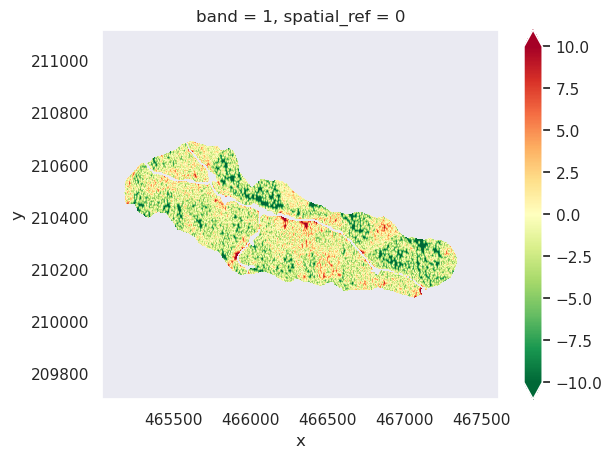

In [63]:
ds.dce_snowoff.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

In [63]:
# saving to a netcdf 
# ds.to_netcdf('/home/lumbraca/raster/data/cer_treatment_region_dataset_simple_cutatzero.nc') # for the snow depth values cut a zero
# ds.to_netcdf('/home/lumbraca/raster/data/cer_treatment_region_dataset_simple_negtozero.nc') # for the snow depth values negative to zeros

ds.to_netcdf('/home/lumbraca/raster/data/cer_treatment_region_dataset_simple.nc') 

In [65]:
ds.close()